# L2 - Multilayer perceptron

### Papers
1. [TensorFlow](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45166.pdf)

### TensorFlow
1. [Installing TensorFlow](https://www.tensorflow.org/install/)
2. [Basics of TensorFlow](https://www.tensorflow.org/get_started/get_started)
3. [Mnist with TensorFlow](https://www.tensorflow.org/get_started/mnist/pros)
4. [TensorFlow Mechanics](https://www.tensorflow.org/get_started/mnist/mechanics)
5. [Visualization](https://www.tensorflow.org/get_started/graph_viz)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.figsize'] = '10,8'

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset with TensorFlow (possible, [this tutorial](https://www.tensorflow.org/get_started/mnist/pros) can help you).
4. Chek accuracy on train and validation sets.
5. Use a local [TensorBoard instance](https://www.tensorflow.org/get_started/graph_viz) to visualize resulted graph (no need to include in lab).

Let 
$$Lp_i = \ln(p_i) = \ln(\exp(w_i^Tx)) - \ln(\sum_j \exp(w_i^Tx)) = w_i^Tx - \ln(\sum_j \exp(w_i^Tx)).$$

Let's find $\frac{dLp_i}{dw_j}:$
$$\frac{dLp_i}{dw_j} = \delta_{ij}x^T - \frac{\exp(w_j^Tx)}{\sum_i w_i^Tx} x^T = (\delta_{ij} - p_j)x^T$$

In [2]:
data = np.genfromtxt("../../train.csv", delimiter=',', skip_header=1)

In [3]:
labels, pictures = data[:, 0].reshape(-1, 1), data[:, 1:] / 255

enc = OneHotEncoder()
enc.fit(labels)
labels = enc.transform(labels).toarray()

X_train, X_test, y_train, y_test = train_test_split(pictures, 
                                                    labels, 
                                                    test_size=0.30, 
                                                    random_state=42,
                                                    shuffle=True)

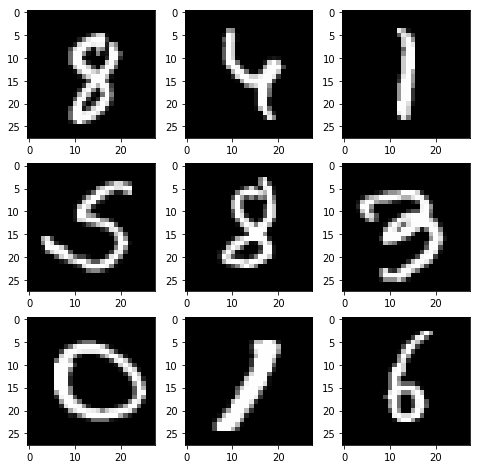

In [4]:
samples_ind = np.random.randint(0, data.shape[0], size=9)
samples_pic = pictures[samples_ind].reshape((9, 28, 28))

plt.figure(9, (8, 8))

for i in range(samples_ind.shape[0]):
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(samples_pic[i], cmap='gray')

In [5]:
def counter():
    r = 0
    while (True):
        r += 1
        yield r

log_path = "./logs/"
run = counter()

In [15]:
tf.reset_default_graph()

with tf.name_scope('input'):
    X = tf.placeholder(tf.float32, shape=[None, 784])
    y_l = tf.placeholder(tf.float32, shape=[None, 10])

with tf.name_scope('weights'):    
    w = tf.Variable(tf.zeros([784, 10]))

with tf.name_scope('biases'):
    b = tf.Variable(tf.zeros([10]))

with tf.name_scope("linearity"):
    y_pr = tf.matmul(X, w) + b

with tf.name_scope("cross_entropy_with_softmax"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_l, logits=y_pr))

with tf.name_scope("train"):
    train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(loss)

with tf.name_scope("Accuracy"):
    true_pred = tf.equal(tf.argmax(y_pr, 1), tf.argmax(y_l, 1))
    accuracy = tf.reduce_mean(tf.cast(true_pred, tf.float32))

tf.summary.scalar("cost", loss)
tf.summary.scalar("accuracy", accuracy)

summary_op = tf.summary.merge_all()

In [16]:
runs = next(run)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

writer = tf.summary.FileWriter('./logs/run_%d'%runs, graph=tf.get_default_graph())

EPOCHS = 300
BATCH_SIZE = 100

for epoch in range(EPOCHS):
    for i in range(X_train.shape[0] // BATCH_SIZE):
        batch_X, batch_y = X_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE], \
                           y_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]

        _, summary = sess.run([train_step, summary_op], feed_dict={X: batch_X, y_l: batch_y})

        writer.add_summary(summary, epoch * BATCH_SIZE + i)

In [17]:
print("Accuracy on train", sess.run(accuracy, feed_dict={X: X_train, y_l: y_train}))
print("Accuracy on test", sess.run(accuracy, feed_dict={X: X_test, y_l: y_test}))

Accuracy on train 0.928878
Accuracy on test 0.918333


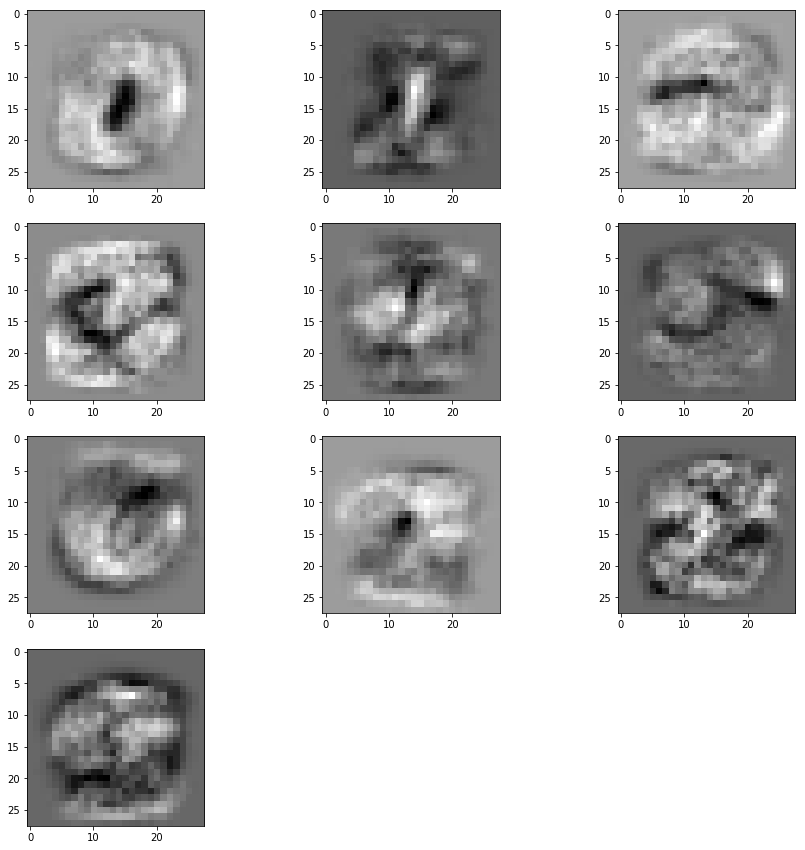

In [19]:
weights = w.eval().reshape((28, 28, 10))

plt.figure(10, (15, 15))

for i in range(weights.shape[2]):
    plt.subplot(4, 3, i + 1)
    
    plt.imshow(weights[:, :, i], cmap='gray')

Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [9]:
l_1 = 1e-5
l_2 = 1e-5

In [10]:
with tf.name_scope("loss_with_regularization"):
    loss_reg = loss + l_1 * tf.reduce_sum(tf.abs(w)) + l_1 * tf.reduce_sum(tf.pow(w, 2))

with tf.name_scope("train_regularizated_model"):
    train_reg = tf.train.GradientDescentOptimizer(0.5).minimize(loss_reg)

In [11]:
runs = next(run)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

writer = tf.summary.FileWriter('./logs/run_%d'%runs, graph=tf.get_default_graph())

EPOCHS = 20
BATCH_SIZE = 100
    
for epoch in range(EPOCHS):
    for i in range(X_train.shape[0] // BATCH_SIZE):
        batch_X, batch_y = X_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE], \
                           y_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
            
        _, summary = sess.run([train_reg, summary_op], feed_dict={X: batch_X, y_l: batch_y})
        writer.add_summary(summary, epoch * BATCH_SIZE + i)

In [12]:
print("Accuracy on train with regularization", sess.run(accuracy, feed_dict={X: X_train, y_l: y_train}))
print("Accuracy on test with regularization", sess.run(accuracy, feed_dict={X: X_test, y_l: y_test}))

Accuracy on train with regularization 0.932959
Accuracy on test with regularization 0.917778


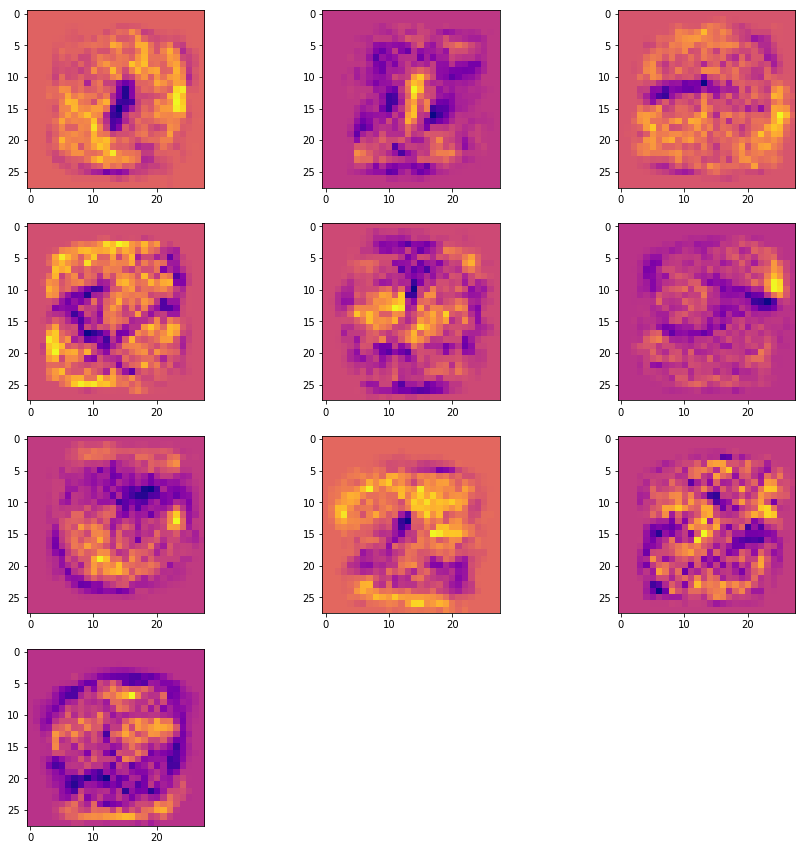

In [14]:
weights = w.eval().reshape((28, 28, 10))

plt.figure(10, (15, 15))

for i in range(weights.shape[2]):
    plt.subplot(4, 3, i + 1)
    
    plt.imshow(weights[:, :, i], cmap='plasma')

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [27]:
def DNN(output_sz, 
        nonlinearity, 
        learn_rate=0.5, 
        epochs=5, 
        batch_size=100, 
        regul_coef=(None, None),
        output=True):
    
    non_l_func = ''
    if (nonlinearity == 'sigmoid'):
        non_l_func = tf.nn.sigmoid
    elif (nonlinearity == 'relu'):
        non_l_func = tf.nn.relu
    elif (nonlinearity == 'lrelu'):
        non_l_func = tf.nn.leaky_relu
    else:
        non_l_func = tf.nn.softmax
    
    tf.reset_default_graph()
    with tf.Session() as sess_2:
        with tf.name_scope("inputs"):
            X = tf.placeholder(tf.float32, shape=[None, 784])
            y_l = tf.placeholder(tf.float32, shape=[None, 10])

        with tf.name_scope("layers"):
            layers = [X]
            
            reg_list = []
            if regul_coef[0] is not None:
                reg_list.append(tf.contrib.layers.l1_regularizer(regul_coef[0]))
            if regul_coef[1] is not None:
                reg_list.append(tf.contrib.layers.l1_regularizer(regul_coef[1]))
            
            
            for i in range(len(output_sz) - 1):
                layers.append(tf.layers.dense(layers[i - 1], 
                                              output_sz[i], 
                                              activation=non_l_func, 
                                              kernel_regularizer=tf.contrib.layers.sum_regularizer(reg_list)))
            layers.append(tf.layers.dense(layers[-1], output_sz[-1]))

        with tf.name_scope("final_softmax"):
            y_pr = tf.nn.softmax(layers[-1])

        with tf.name_scope("loss"):
            loss = tf.losses.softmax_cross_entropy(y_l, layers[-1])

        with tf.name_scope("train"):
            train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        with tf.name_scope("Accuracy"):
            true_pred = tf.equal(tf.argmax(y_pr, 1), tf.argmax(y_l, 1))
            accuracy = tf.reduce_mean(tf.cast(true_pred, tf.float32))

        tf.summary.scalar("cost", loss)
        tf.summary.scalar("accuracy", accuracy)

        summary_op = tf.summary.merge_all()
        
        runs = next(run)
        sess_2.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('./logs/run_%d'%runs, graph=tf.get_default_graph())

        for epoch in range(epochs):
            for i in range(X_train.shape[0] // batch_size):
                batch_X, batch_y = X_train[i * batch_size: (i + 1) * batch_size], \
                                   y_train[i * batch_size: (i + 1) * batch_size]

                _, summary = sess_2.run([train, summary_op], feed_dict={X: batch_X, y_l: batch_y})
                writer.add_summary(summary, epoch * batch_size + i)
        
        arg = [len(output_sz), nonlinearity]
        train_acc = sess_2.run(accuracy, feed_dict={X: X_train, y_l: y_train})
        test_acc = sess_2.run(accuracy, feed_dict={X: X_test, y_l: y_test})
        
        if output:
            print("Accuracy on train %d layers + %s train "%(len(output_sz), nonlinearity), train_acc)
            print("Accuracy on test %d layers + %s layers"%(len(output_sz), nonlinearity), test_acc)
        
        return train_acc, test_acc

In [28]:
%time DNN(output_sz=[400, 10], nonlinearity='sigmoid', epochs=30, batch_size=100)

print('='*30)


%time DNN(output_sz=[400, 10], nonlinearity='relu', epochs=30, batch_size=100)

print('='*30)


%time DNN(output_sz=[400, 10], nonlinearity='lrelu', epochs=30, batch_size=100);

Accuracy on train 2 layers + sigmoid train  0.989218
Accuracy on test 2 layers + sigmoid layers 0.968254
CPU times: user 1min 26s, sys: 8.26 s, total: 1min 34s
Wall time: 42.3 s
Accuracy on train 2 layers + relu train  1.0
Accuracy on test 2 layers + relu layers 0.976349
CPU times: user 1min 27s, sys: 4.12 s, total: 1min 31s
Wall time: 41.1 s
Accuracy on train 2 layers + lrelu train  1.0
Accuracy on test 2 layers + lrelu layers 0.974603
CPU times: user 1min 28s, sys: 4.82 s, total: 1min 33s
Wall time: 39.7 s


(1.0, 0.97460318)

In [29]:
DNN(output_sz=[600, 400, 200, 100, 50, 10], 
    nonlinearity='relu', 
    epochs=30, 
    batch_size=60, 
    regul_coef=(1e-5, 1e-5));

Accuracy on train 6 layers + relu train  1.0
Accuracy on test 6 layers + relu layers 0.978651


In [30]:
acc_lay = [] 

for i in range(1, 10):
    layers_sz = np.linspace(684, 10, i + 1, dtype=np.int)
    _, test_acc = DNN(output_sz=layers_sz, 
                      nonlinearity='sigmoid', 
                      epochs=20, 
                      batch_size=100,
                      regul_coef=[1e-5, 1e-5])
    acc_lay.append(test_acc)

Accuracy on train 2 layers + sigmoid train  0.977585
Accuracy on test 2 layers + sigmoid layers 0.960635
Accuracy on train 3 layers + sigmoid train  0.979626
Accuracy on test 3 layers + sigmoid layers 0.962143
Accuracy on train 4 layers + sigmoid train  0.969694
Accuracy on test 4 layers + sigmoid layers 0.957063
Accuracy on train 5 layers + sigmoid train  0.971224
Accuracy on test 5 layers + sigmoid layers 0.958571
Accuracy on train 6 layers + sigmoid train  0.965
Accuracy on test 6 layers + sigmoid layers 0.953651
Accuracy on train 7 layers + sigmoid train  0.967483
Accuracy on test 7 layers + sigmoid layers 0.955635
Accuracy on train 8 layers + sigmoid train  0.960136
Accuracy on test 8 layers + sigmoid layers 0.94754
Accuracy on train 9 layers + sigmoid train  0.964218
Accuracy on test 9 layers + sigmoid layers 0.950952
Accuracy on train 10 layers + sigmoid train  0.737585
Accuracy on test 10 layers + sigmoid layers 0.730397


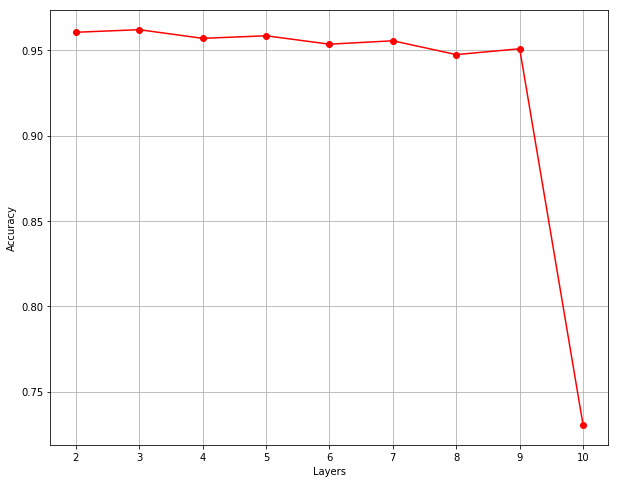

In [31]:
plt.plot(range(2, 11), acc_lay, 'r-o')
plt.xlabel("Layers")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.

In [6]:
class AutoEncoder():
    def __init__(self):
        self.graph = tf.Graph()
        self.layers = []    
    
    def add_input(self, input_shape, dtype=tf.float32):
        self.dtype = dtype
        
        with self.graph.as_default():
            with tf.name_scope("input"):
                self.X = tf.placeholder(tf.float32, shape=input_shape, name="X")
                self.layers.append(self.X)
    
    
    def add_layer(self, 
                  output_sz,
                  input_lay=None,
                  activation=tf.nn.relu,
                  regularization=tf.contrib.layers.l1_l2_regularizer(1e-5, 1e-5)):
        
        if input_lay is None:
            input_lay = self.layers[-1]
        
        with self.graph.as_default():
            self.layers.append(tf.layers.dense(input_lay, 
                                               output_sz,
                                               kernel_regularizer=regularization))
    
    def add_output(self,
                   output_shape,
                   input_lay=None):
        
        if input_lay is None:
            input_lay = self.layers[-1]

        with self.graph.as_default():
            with tf.name_scope("output"):
                self.y_l = tf.placeholder(self.dtype, shape=output_shape, name="y_l")
            
            with tf.name_scope("prediction"):
                self.y_pr = tf.identity(self.layers[-1], name='y_pr')
    
    
    def set_train_params(self,
                         optimizer=tf.train.GradientDescentOptimizer(0.5),
                         loss=tf.losses.mean_squared_error):
        
        with self.graph.as_default():
            with tf.name_scope("loss/"):
                self.loss = loss(self.y_l, self.y_pr)
                tf.summary.scalar("loss", self.loss)
            
            with tf.name_scope("train"):
                self.train = optimizer.minimize(self.loss)
                
            with tf.name_scope("accuracy"):
                true_pred = tf.equal(tf.argmax(self.y_pr, 1), tf.argmax(self.y_l, 1))
                self.accuracy = tf.reduce_mean(tf.cast(true_pred, tf.float32))
                tf.summary.scalar("accuracy", self.accuracy)
                
    
    def fit(self,
            X_t,
            y_t,
            epochs=10,
            batch_size=100):
        
        self.sess = tf.InteractiveSession(graph=self.graph)
        self.summary_op = tf.summary.merge_all()

        self.runs = next(run)
        self.sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('./logs/run_%d'%self.runs, graph=self.graph)

        for epoch in range(epochs):
            for i in range(X_t.shape[0] // batch_size):
                batch_X, batch_y = X_t[i * batch_size: (i + 1) * batch_size], \
                                   y_t[i * batch_size: (i + 1) * batch_size]

                _, summary = self.sess.run([self.train, self.summary_op], 
                                      feed_dict={self.X: batch_X, self.y_l: batch_y})
                writer.add_summary(summary, epoch * batch_size + i)
                
    
    def predict(self, X_t):
        return np.asarray(self.sess.run([self.y_pr], feed_dict={self.X: X_t})[0])
    
    
    def predict_n_lay(self, num, X_t):
        return np.asarray(self.sess.run([self.layers[num]], feed_dict={self.X: X_t})[0])
    
    
    def get_tensors(self):
        return self.layers
    
    
    def get_y_lab(self):
        return self.y_l
    
    
    def close(self):
        self.sess.close()

In [33]:
a = AutoEncoder()
a.add_input([None, 784])
a.add_layer(3)
a.add_layer(784, regularization=None)
a.add_output([None, 784])
a.set_train_params(optimizer=tf.train.AdamOptimizer())
a.fit(X_train, X_train, epochs=20)

In [34]:
digits = []
lb = np.argmax(y_train, axis=1).reshape(-1, 1)
NDOTS = 100

for i in range(10):
    ind = lb == i
    cur_dig = X_train[ind.flatten()][:NDOTS]    
    digits.append(cur_dig)

digits = np.asarray(digits).reshape(10 * NDOTS, 784)

get_3d = np.swapaxes(a.predict_n_lay(1, digits), 0, 1)

<IPython.core.display.Javascript object>


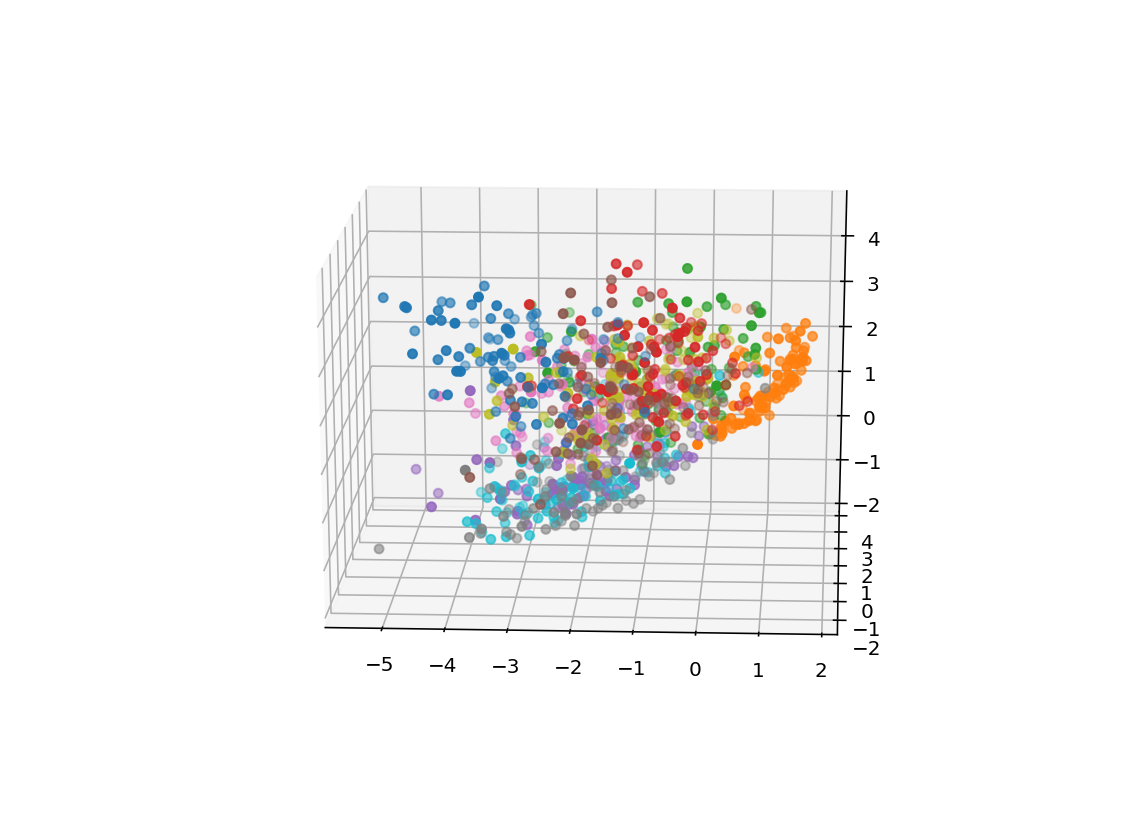

In [36]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range (10):
    ax.scatter(get_3d[0, i * NDOTS: (i + 1) * NDOTS], \
               get_3d[1, i * NDOTS: (i + 1) * NDOTS], \
               get_3d[2, i * NDOTS: (i + 1) * NDOTS]);

As we see similar digits form a "cloud". It means that similar digits are very close to each other.

In [37]:
from sklearn.manifold import TSNE
get_3d_tsne = TSNE(n_components=3).fit_transform(get_3d.T).T

<IPython.core.display.Javascript object>


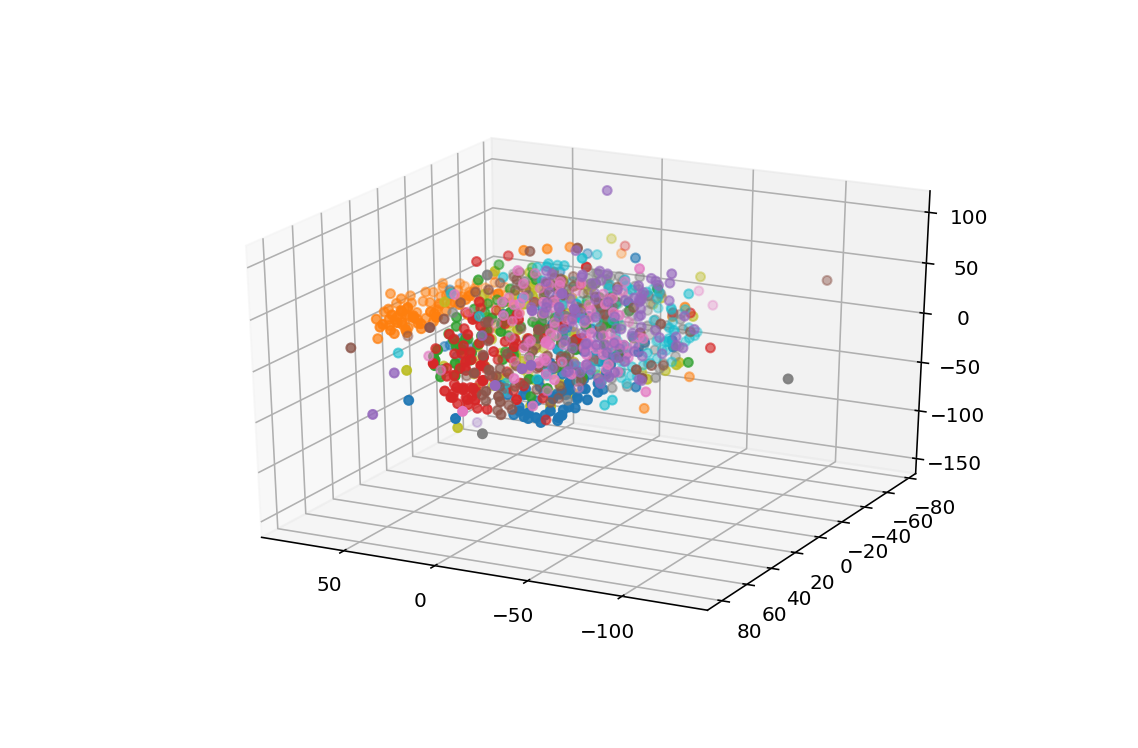

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range (10):
    ax.scatter(get_3d_tsne[0, i * NDOTS: (i + 1) * NDOTS], \
               get_3d_tsne[1, i * NDOTS: (i + 1) * NDOTS], \
               get_3d_tsne[2, i * NDOTS: (i + 1) * NDOTS]);

We can see it more clearly after applying the tSNE algorithm to our points.

In [46]:
a.close()
a = AutoEncoder()
a.add_input([None, 784])
a.add_layer(300)
a.add_layer(3)
a.add_layer(300)
a.add_layer(784, regularization=None)
a.add_output([None, 784])
a.set_train_params(optimizer=tf.train.AdamOptimizer())
a.fit(X_train, X_train, epochs=20)

In [47]:
get_3d_4_lay = np.swapaxes(a.predict_n_lay(2, digits), 0, 1)
a.close()

<IPython.core.display.Javascript object>


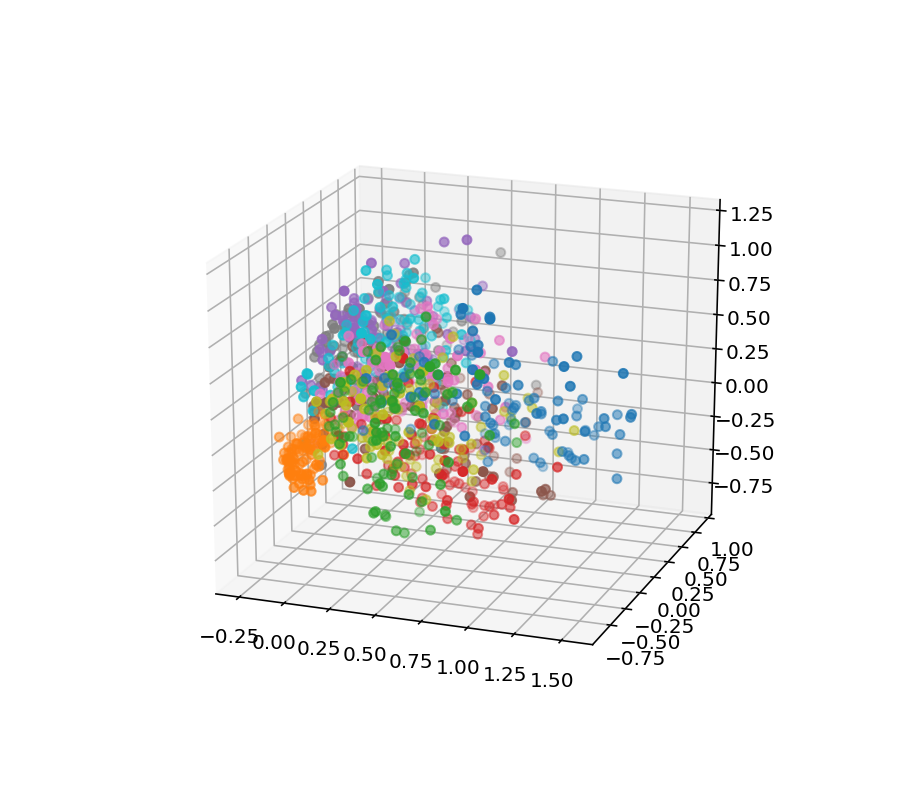

In [49]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range (10):
    ax.scatter(get_3d_4_lay[0, i * NDOTS: (i + 1) * NDOTS], \
               get_3d_4_lay[1, i * NDOTS: (i + 1) * NDOTS], \
               get_3d_4_lay[2, i * NDOTS: (i + 1) * NDOTS]);

As we see "clouds" became more distinct after using 5 layers autoencoder.

In [9]:
def encode_and_classify(train_data,
                        train_labels,
                        test_data,
                        test_labels,
                        nth_lay_encode_as_inp,
                        encode_layers_sizes,
                        classify_layers_sizes,
                        epochs=20,
                        batch_size=100,
                        regul_coef = [None, None]):
        
    auto = AutoEncoder()
    auto.add_input([None, encode_layers_sizes[0]])
        
    for i in range(1, len(encode_layers_sizes)):
        print("lay auto", encode_layers_sizes[i])
        auto.add_layer(encode_layers_sizes[i])
        
    auto.add_output([None, encode_layers_sizes[-1]])
        
    auto.set_train_params(optimizer=tf.train.AdamOptimizer())
    auto.fit(train_data, train_data, epochs=epochs)
    
    pre_trained_tr = auto.predict_n_lay(nth_lay_encode_as_inp, train_data)
    pre_trained_tst = auto.predict_n_lay(nth_lay_encode_as_inp, test_data)
    
    pics = auto.predict(train_data).reshape((train_data.shape[0], 28, 28))
        
    auto.close()
        
    tf.reset_default_graph()
    with tf.name_scope("c_input"):
        X = tf.placeholder(tf.float32, shape=[None, classify_layers_sizes[0]])
        y_l = tf.placeholder(tf.float32, shape=[None, classify_layers_sizes[-1]])
        
    with tf.name_scope("c_layers"):
        layers = [X]
        reg_list = []
        
        if regul_coef[0] is not None:
            reg_list.append(tf.contrib.layers.l1_regularizer(regul_coef[0]))
        if regul_coef[1] is not None:
            reg_list.append(tf.contrib.layers.l1_regularizer(regul_coef[1]))


        for i in range(len(classify_layers_sizes) - 1):
            layers.append(tf.layers.dense(layers[i - 1], 
                                          classify_layers_sizes[i], 
                                          activation=tf.nn.relu, 
                                          kernel_regularizer=tf.contrib.layers.sum_regularizer(reg_list)))
        layers.append(tf.layers.dense(layers[-1], classify_layers_sizes[-1]))

    with tf.name_scope("final_softmax"):
        y_pr = tf.nn.softmax(layers[-1])

    with tf.name_scope("loss_nn"):
        loss = tf.losses.softmax_cross_entropy(y_l, layers[-1])

    with tf.name_scope("train_nn"):
        train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    with tf.name_scope("Accuracy_nn"):
        true_pred = tf.equal(tf.argmax(y_pr, 1), tf.argmax(y_l, 1))
        accuracy = tf.reduce_mean(tf.cast(true_pred, tf.float32))

    tf.summary.scalar("cost_nn", loss)
    tf.summary.scalar("accuracy_nn", accuracy)

    summary_op = tf.summary.merge_all()

    runs = next(run)
    
    sess_2 = tf.InteractiveSession()
    sess_2.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./logs/run_%d'%runs, graph=tf.get_default_graph())

    for epoch in range(epochs):
        for i in range(pre_trained_tr.shape[0] // batch_size):
            batch_X, batch_y = pre_trained_tr[i * batch_size: (i + 1) * batch_size], \
                               train_labels[i * batch_size: (i + 1) * batch_size]

            _, summary = sess_2.run([train, summary_op], feed_dict={X: batch_X, y_l: batch_y})
            writer.add_summary(summary, epoch * batch_size + i)

    train_acc = sess_2.run(accuracy, feed_dict={X: pre_trained_tr, y_l: train_labels})
    test_acc = sess_2.run(accuracy, feed_dict={X: pre_trained_tst, y_l: test_labels})
    
    sess_2.close()

    n = classify_layers_sizes
    print("Accuracy on train with 2 pretrained layers + %d supervised"%, train_acc)
    print("Accuracy on test with 2 pretrained layers + %d supervised"%, test_acc)

In [10]:
encode_and_classify(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    nth_lay_encode_as_inp=2,
                    encode_layers_sizes=[784, 500, 300, 500, 784],
                    classify_layers_sizes=[300, 100, 10], 
                    regul_coef=[1e-5, 1e-5])

encode lays [784, 500, 300, 500, 784]
inp auto [None, 784]
lay auto 500
lay auto 300
lay auto 500
lay auto 784
out [None, 784]
pretrain_tr shape (29400, 300)
pretrain_tst shape (12600, 300)
X [None, 300]
y_l out [None, 10]
cl llay sz 300
cl llay sz 100
cl out sz 10
Accuracy on train 0.999626
Accuracy on test 0.969127
